In [1]:
from tsai.basics import *
import sktime
import sklearn
import get_processed_data as gpd
from tsai.models.MINIROCKET_Pytorch import *
from tsai.models.utils import *

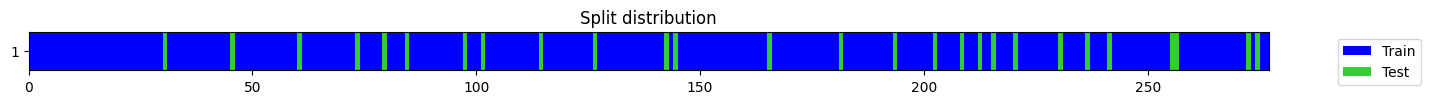

In [2]:
train, test = gpd.get_train_test_split("malte", 10*60, 5*60)

train_easy = train["easy"]
train_hard = train["hard"]

test_easy = test["easy"]
test_hard = test["hard"]

y_train_easy = np.full(len(train_easy), 'easy', dtype=object)
y_train_hard = np.full(len(train_hard), 'hard', dtype=object)
y_test_easy = np.full(len(test_easy), 'easy', dtype=object)
y_test_hard = np.full(len(test_hard), 'hard', dtype=object)

X = np.concatenate([train_easy, train_hard])
y = np.concatenate([y_train_easy, y_train_hard])

X = np.stack([np.transpose(np.array(x[['Quat_W', 'Quat_X', 'Quat_Y', 'Quat_Z', 'FreeAcc_X', 'FreeAcc_Y', 'FreeAcc_Z']].tolist()), (1, 0)) for x in X])

# create an array with two arrays inside for train and test. the train array contains the indices of the train samples and the test array the indices of the test samples
splits = get_splits(range(len(train_easy) + len(train_hard)), 1, 0.1, random_state=42)

X_test = np.concatenate([test_easy, test_hard])
y_test = np.concatenate([y_test_easy, y_test_hard])
X_test = np.stack([np.transpose(np.array(x[['Quat_W', 'Quat_X', 'Quat_Y', 'Quat_Z', 'FreeAcc_X', 'FreeAcc_Y', 'FreeAcc_Z']].tolist()), (1, 0)) for x in X_test])


## Without Augmentation

epoch,train_loss,valid_loss,accuracy,time
0,0.682458,0.684490,0.777778,00:02
1,0.658335,0.669336,0.777778,00:00
2,0.623930,0.644806,0.814815,00:00
3,0.575725,0.610722,0.851852,00:00
4,0.535421,0.568680,0.851852,00:00
5,0.492743,0.526584,0.925926,00:00
6,0.456177,0.485052,0.925926,00:00
7,0.412436,0.442041,0.925926,00:00
8,0.380831,0.403540,0.962963,00:00
9,0.351120,0.367624,0.962963,00:00


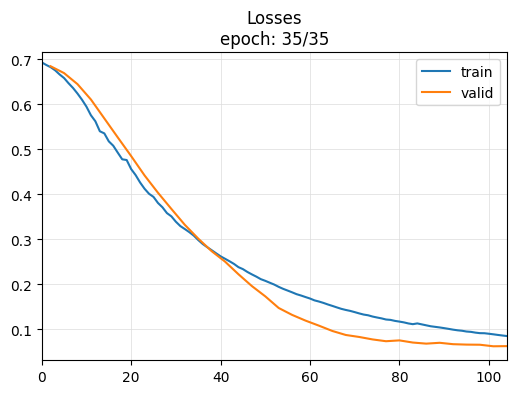

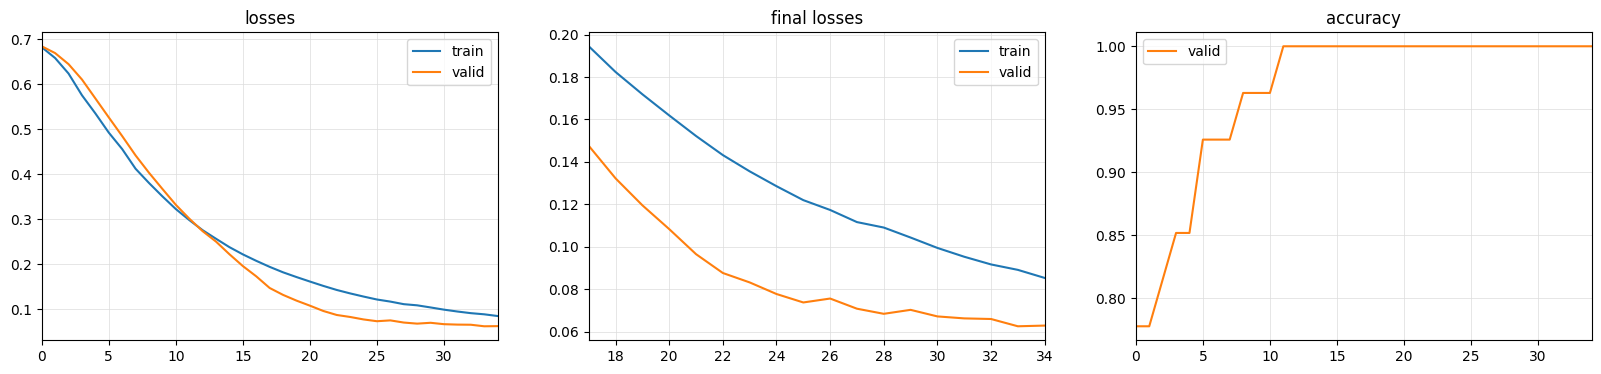

Total time              : 24.945028


In [7]:
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
model = build_ts_model(MiniRocket, dls=dls)
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraph())
timer.start()
learn.fit_one_cycle(35, 2e-4)
timer.stop()

PATH = Path('./models/MiniRocket.pkl')
PATH.parent.mkdir(parents=True, exist_ok=True)
learn.export(PATH)

In [14]:
del learn

In [15]:
PATH = Path('./models/MiniRocket.pkl')
learn = load_learner(PATH, cpu=False)

In [16]:
probas, _, preds = learn.get_X_preds(X_test)
sklearn.metrics.accuracy_score(y_test, preds)

0.9090909090909091